# Milestone Project: 🍔👁 Food Vision Big™

We're going to be building Food Vision Big™, using all of the data from the Food101 dataset.


This time **we've got the goal of beating [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment)**, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.

> 🔑 **Note:** **Top-1 accuracy** means "accuracy for the top softmax activation value output by the model" (because softmax ouputs a value for every class, but top-1 means only the highest one is evaluated). **Top-5 accuracy** means "accuracy for the top 5 softmax activation values output by the model", in other words, did the true label appear in the top 5 activation values? Top-5 accuracy scores are usually noticeably higher than top-1.


Alongside attempting to beat the DeepFood paper, we're going to learn about two methods to significantly improve the speed of our model training:
1. Prefetching
2. Mixed precision training


## Project Planning

* Using TensorFlow Datasets to download and explore data
* Creating preprocessing function for our data
* Batching & preparing datasets for modelling (**making our datasets run fast**)
* Creating modelling callbacks
* Setting up **mixed precision training**
* Building a feature extraction model
* Fine-tuning the feature extraction model



In [1]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-419192a4-4a0f-2a79-8743-a9410fafcfc6)


In [2]:
# Install tf-nightly (required until 2.13.0+ is the default in Google Colab)
# !pip install -U -q tf-nightly

# Check TensorFlow version (should be minimum 2.4.0+ but 2.13.0+ is better)
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.14.0


## Get helper functions

We've created a series of helper functions throughout the previous notebooks in the course. Instead of rewriting them (tedious), we'll import the [`helper_functions.py`](https://raw.githubusercontent.com/VrajMalvi/tensor-flow-learning/main/helper_functions.py) file from the GitHub repo.

In [3]:
# Get helper functions file
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/VrajMalvi/tensor-flow-learning/main/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

--2023-11-10 00:27:45--  https://raw.githubusercontent.com/VrajMalvi/tensor-flow-learning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-10 00:27:45 (119 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# import useful function from heper_function notebook
from helper_functions import plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

For many of the most popular datasets in the machine learning world (often referred to and used as benchmarks), you can access them through [TensorFlow Datasets (TFDS)](https://www.tensorflow.org/datasets/overview).

What is **TensorFlow Datasets**?

A place for prepared and ready-to-use machine learning datasets.

Why use TensorFlow Datasets?

* Load data already in Tensors
* Practice on well established datasets
* Experiment with differet data loading techniques (like we're going to use in this notebook)
* Experiment with new TensorFlow features quickly (such as mixed precision training)

Why *not* use TensorFlow Datasets?

* The datasets are static (they don't change, like your real-world datasets would)
* Might not be suited for your particular problem (but great for experimenting)

To begin using TensorFlow Datasets we can import it under the alias `tfds`.


In [5]:
## use tensoflow data set to download data
import tensorflow_datasets as tfds

To find all of the available datasets in TensorFlow Datasets, you can use the `list_builders()` method.

After doing so, we can check to see if the one we're after (`"food101"`) is present.

In [6]:
# list available dataset in tensorflow
dataset_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in dataset_list) # is our dataset in TFDS ?

True


Beautiful! It looks like the dataset we're after is available (note there are plenty more available but we're on Food101).

To get access to the Food101 dataset from the TFDS, we can use the [`tfds.load()`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load) method.

In particular, we'll have to pass it a few parameters to let it know what we're after:
* `name` (str) : the target dataset (e.g. `"food101"`)
* `split` (list, optional) : what splits of the dataset we're after (e.g. `["train", "validation"]`)
  * the `split` parameter is quite tricky. See [the documentation for more](https://github.com/tensorflow/datasets/blob/master/docs/splits.md).
* `shuffle_files` (bool) : whether or not to shuffle the files on download, defaults to `False`
* `as_supervised` (bool) : `True` to download data samples in tuple format (`(data, label)`) or `False` for dictionary format
* `with_info` (bool) : `True` to download dataset metadata (labels, number of samples, etc)

> 🔑 **Note:** Calling the `tfds.load()` method will start to download a target dataset to disk if the `download=True` parameter is set (default). This dataset could be 100GB+, so make sure you have space.

In [12]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Nov 10 00:33:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    39W / 300W |    520MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
# download data in tensorformat using tensorflow
# load in the data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data get returned in tuple format
                                             with_info=True  # gives metadata for dataset which will stored in "ds_info"
                                             )

Wonderful! After a few minutes of downloading, we've now got access to entire Food101 dataset (in tensor format) ready for modelling.

Now let's get a little information from our dataset, starting with the class names.

Getting class names from a TensorFlow Datasets dataset requires downloading the "`dataset_info`" variable (by using the `as_supervised=True` parameter in the `tfds.load()` method, **note:** this will only work for supervised datasets in TFDS).

We can access the class names of a particular dataset using the `dataset_info.features` attribute and accessing `names` attribute of the the `"label"` key.

In [14]:
# Features of Food101
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [15]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### Exploring the Food101 data from TensorFlow Datasets

Now we've downloaded the Food101 dataset from TensorFlow Datasets, how about we do what any good data explorer should?

In other words, "visualize, visualize, visualize".

Let's find out a few details about our dataset:
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names?

To do, let's take one sample off the training data (using the [`.take()` method](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take)) and explore it.

Because we used the `as_supervised=True` parameter in our `tfds.load()` method above, data samples come in the tuple format structure `(data, label)` or in our case `(image_tensor, label)`.

In [16]:
# Take one sample of train data (shiffle is on so if we run this cell we might get different data)
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)
# what does one sample of training data looks likes
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Let's loop through our single training sample and get some info from the `image_tensor` and `label`.

In [17]:
# output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image Shape: {image.shape}
  Imaage DataType: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image Shape: (512, 512, 3)
  Imaage DataType: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 8
  Class name (str form): bread_pudding
  


In [18]:
label # we have used numpy() to get the value directly

<tf.Tensor: shape=(), dtype=int64, numpy=8>

Because we set the `shuffle_files=True` parameter in our `tfds.load()` method above, running the cell above a few times will give a different result each time.

Checking these you might notice some of the images have different shapes, for example `(512, 512, 3)` and `(512, 342, 3)` (height, width, color_channels).

Let's see what one of the image tensors from TFDS's Food101 dataset looks like.

In [19]:
# what is our image tensor look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[18,  6,  8],
        [18,  6,  8],
        [18,  6,  8],
        ...,
        [30, 15, 22],
        [29, 14, 21],
        [26, 11, 18]],

       [[22, 10, 12],
        [21,  9, 11],
        [20,  8, 10],
        ...,
        [35, 20, 27],
        [31, 16, 23],
        [26, 11, 18]],

       [[23, 13, 14],
        [21, 11, 12],
        [19,  9, 10],
        ...,
        [39, 26, 33],
        [36, 21, 28],
        [30, 15, 22]],

       ...,

       [[15,  4,  8],
        [15,  4,  8],
        [14,  5, 10],
        ...,
        [41,  9, 10],
        [39,  7,  8],
        [36,  4,  5]],

       [[16,  5,  9],
        [16,  5,  9],
        [16,  5, 11],
        ...,
        [42, 12, 12],
        [39,  9,  9],
        [35,  5,  5]],

       [[15,  4,  8],
        [15,  4,  8],
        [16,  5, 11],
        ...,
        [41, 11, 11],
        [39,  9,  9],
        [35,  5,  5]]], dtype=uint8)>

In [20]:
# what are min and max values of out image tensor
import tensorflow as tf

tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Alright looks like our image tensors have values of between 0 & 255 (standard red, green, blue colour values) and the values are of data type `unit8`.

We might have to preprocess these before passing them to a neural network. But we'll handle this later.

let's see if we can plot an image sample.

### Plot an image from TensorFlow Datasets

We've seen our image tensors in tensor format, now let's really adhere to our motto.

"Visualize, visualize, visualize!"

Let's plot one of the image samples using [`matplotlib.pyplot.imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) and set the title to target class name.

(-0.5, 511.5, 511.5, -0.5)

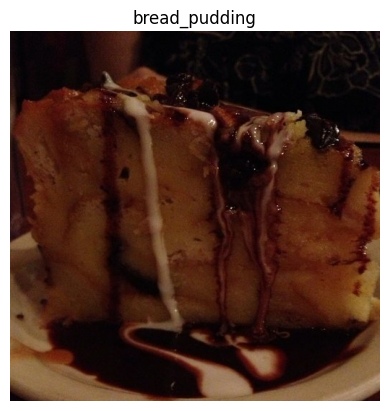

In [21]:
# Plot image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to verify the label is associated with right image
plt.axis(False)

Okay, looks like the Food101 data we've got from TFDS is similar to the datasets we've been using in previous notebooks.

Now let's preprocess it and get it ready for use with a neural network.

## Create preprocessing functions for our data

since we've downloaded the data from TensorFlow Datasets, there are a couple of preprocessing steps we have to take before it's ready to model.

More specifically, our data is currently:

* In `uint8` data type
* Comprised of all differnet sized tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:

* In `float32` data type
* Have all of the same size tensors (batches require all tensors have the same shape, e.g. `(224, 224, 3)`)
* Scaled (values between 0 & 1), also called normalized

To take care of these, we'll create a `preprocess_img()` function which:

* Resizes an input image tensor to a specified size using [`tf.image.resize()`](https://www.tensorflow.org/api_docs/python/tf/image/resize)
* Converts an input image tensor's current datatype to `tf.float32` using [`tf.cast()`](https://www.tensorflow.org/api_docs/python/tf/cast)

> 🔑 **Note:** Pretrained EfficientNetBX models in [`tf.keras.applications.efficientnet`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet) (what we're going to be using) have rescaling built-in. But for many other model architectures you'll want to rescale your data (e.g. get its values between 0 & 1). This could be incorporated inside your "`preprocess_img()`" function (like the one below) or within your model as a [`tf.keras.layers.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) layer.

In [22]:
# Make a function for Preprocessing images
def preprocess_img(image, label, image_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshaps image to
  [imag_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [image_shape, image_shape])
  return tf.cast(image, tf.float32), label # return (float_32image, label) tuple

Our `preprocess_img()` function above takes image and label as input (even though it does nothing to the label) because our dataset is currently in the tuple structure `(image, label)`.

Let's try our function out on a target image.

In [23]:
# Preprocess single a sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0] # it returns tuple of image and label and we want img only
print(f"Image before preprocesing:\n {image[:2]}...., \nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocesing:\n {preprocessed_img[:2]}...., \nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}\n")

Image before preprocesing:
 [[[18  6  8]
  [18  6  8]
  [18  6  8]
  ...
  [30 15 22]
  [29 14 21]
  [26 11 18]]

 [[22 10 12]
  [21  9 11]
  [20  8 10]
  ...
  [35 20 27]
  [31 16 23]
  [26 11 18]]]...., 
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocesing:
 [[[20.158163   8.158163  10.158163 ]
  [18.42347    7.6173472  9.020408 ]
  [15.010203   6.423469   9.285714 ]
  ...
  [26.285824  15.714351  23.07156  ]
  [31.091867  17.285728  24.285728 ]
  [28.754953  13.754952  20.754953 ]]

 [[18.92857    8.928571   9.928571 ]
  [16.214285   7.0765305  8.07653  ]
  [14.739796   8.571429  10.627552 ]
  ...
  [26.444029  15.872557  21.658293 ]
  [39.86226   26.862259  33.86226  ]
  [39.49479   24.494787  31.494787 ]]]...., 
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>



Excellent!  our `preprocess_img()` function is working as expected.

The input image gets converted from `uint8` to `float32` and gets reshaped from its current shape to `(224, 224, 3)`.

How does it look?

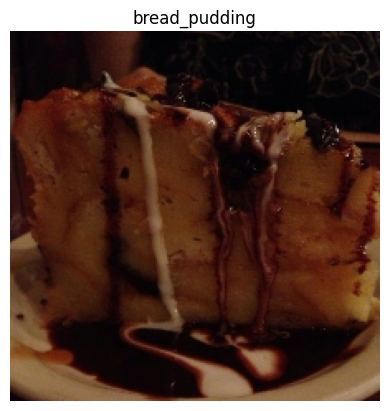

In [24]:
# We can still plot our preprocessed image as long as we
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

## Batch & prepare datasets

Before we can model our data, we have to turn it into batches.

Why?

Because computing on batches is memory efficient.

We turn our data from 101,000 image tensors and labels (train and test combined) into batches of 32 image and label pairs, thus enabling it to fit into the memory of our GPU.

To do this in effective way, we're going to be leveraging a number of methods from the [`tf.data` API](https://www.tensorflow.org/api_docs/python/tf/data).

> 📖 **Resource:** For loading data in the most performant way possible, see the TensorFlow docuemntation on [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance).

Specifically, we're going to be using:

* [`map()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) - maps a predefined function to a target dataset (e.g. `preprocess_img()` to our image tensors)
* [`shuffle()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) - randomly shuffles the elements of a target dataset up `buffer_size` (ideally, the `buffer_size` is equal to the size of the dataset, however, this may have implications on memory)
* [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) - turns elements of a target dataset into batches (size defined by parameter `batch_size`)
* [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
* Extra: [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory)

Things to note:
- Can't batch tensors of different shapes (e.g. different image sizes, need to reshape images first, hence our `preprocess_img()` function)
- `shuffle()` keeps a buffer of the number you pass it images shuffled, ideally this number would be all of the samples in your training set, however, if your training set is large, this buffer might not fit in memory (a fairly large number like 1000 or 10000 is usually suffice for shuffling)
- For methods with the `num_parallel_calls` parameter available (such as `map()`), setting it to`num_parallel_calls=tf.data.AUTOTUNE` will parallelize preprocessing and significantly improve speed (use all available resource as dataset is large)
- Can't use `cache()` unless your dataset can fit in memory



We're going to through things in the following order:

```
Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset
```

This is like saying,

> "Hey, map this preprocessing function across our training dataset, then shuffle a number of elements before batching them together and make sure you prepare new batches (prefetch) whilst the model is looking through the current batch".

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-prefetching-from-hands-on-ml.png)



In [25]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data dn turn it into batchs and prefatch it (load it fater, prepare upcoming data for while current one is being processed)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test_data (and parallelize)
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle test_data dn turn it into batchs and prefatch it (load it fater, prepare upcoming data for while current one is being processed)
test_data = test_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [26]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

Excellent! our data is now in tutples of `(image, label)` with datatypes of `(tf.float32, tf.int64)`, just what our model is after.

> 🔑 **Note:** You can get away without calling the `prefetch()` method on the end of your datasets, however, you'd probably see significantly slower data loading speeds when building a model. So most of your dataset input pipelines should end with a call to [`prefecth()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch).


## Create modelling callbacks

Since we're going to be training on a large amount of data and training could take a long time, it's a good idea to set up some modelling callbacks so we be sure of our model being checkpointed (saved) after various training milestones.

To do each of these we'll use the following callback:

* [`tf.keras.callbacks.ModelCheckpoint()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it
  * Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits

In [27]:
# Create model checkpoint callback to save model'sprocess during trainng
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_acc',
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0  # dont print weather model is being saved or not
                                                      )

## Setup mixed precision training


Normally, tensors in TensorFlow default to the float32 datatype (unless otherwise specified).

In computer science, float32 is also known as [single-precision floating-point format](https://en.wikipedia.org/wiki/Single-precision_floating-point_format). The 32 means it usually occupies 32 bits in computer memory.

GPU has a limited memory, therefore it can only handle a number of float32 tensors at the same time.

This is where mixed precision training comes in.

Mixed precision training involves using a mix of float16 and float32 tensors to make better use of your GPU's memory.

float16 means [half-precision floating-point format](https://en.wikipedia.org/wiki/Half-precision_floating-point_format).

For tensors in float16 format, each element occupies 16 bits in computer memory.

when using mixed precision training, your model will make use of float32 and float16 data types to use less memory where possible and in turn run faster (using less memory per tensor means more tensors can be computed on simultaneously).

As a result, using mixed precision training can improve your performance on modern GPUs (those with a compute capability score of 7.0+) by up to 3x.

For a more detailed explanation, I encourage you to read through the [TensorFlow mixed precision guide](https://www.tensorflow.org/guide/mixed_precision) (I'd highly recommend at least checking out the summary).

*Because mixed precision training uses a combination of float32 and float16 data types, you may see up to a 3x speedup on modern GPUs.*

> 🔑 **Note:** If your GPU doesn't have a score of over 7.0+ (e.g. P100 in Google Colab), mixed precision won't work (see: ["Supported Hardware"](https://www.tensorflow.org/guide/mixed_precision#supported_hardware) in the mixed precision guide for more).


Okay, enough talk, let's see how we can turn on mixed precision training in TensorFlow.

The beautiful thing is, the [`tensorflow.keras.mixed_precision`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/) API has made it very easy for us to get started.

First, we'll import the API and then use the [`set_global_policy()`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/set_global_policy) method to set the *dtype policy* to `"mixed_float16"`.


In [28]:
# Turn on Mixed_precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

Nice! As long as the GPU you're using has a compute capability of 7.0+ the cell above should run without error.

Now we can check the global dtype policy (the policy which will be used by layers in our model) using the [`mixed_precision.global_policy()`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/global_policy) method.

In [29]:
tf.keras.mixed_precision.global_policy() # should output "mixed_float16" (if your GPU is compatible with mixed precision)

<Policy "mixed_float16">

Great, since the global dtype policy is now `"mixed_float16"` our model will automatically take advantage of float16 variables where possible and in turn speed up training.

## Build feature extraction model

Callbacks: ready to roll.

Mixed precision: turned on.

Let's build a model.

Because our dataset is quite large, we're going to move towards fine-tuning an existing pretrained model (EfficienetNetB0).

But before we get into fine-tuning, let's set up a feature-extraction model.

the typical order for using transfer learning is:

1. Build a feature extraction model (replace the top few layers of a pretrained model)
2. Train for a few epochs with lower layers frozen
3. Fine-tune if necessary with multiple layers unfrozen

*Before fine-tuning, it's best practice to train a feature extraction model with custom top layers.*

To build the feature extraction model, we'll:
* Use `EfficientNetB0` from [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) pre-trained on ImageNet as our base model
  * We'll download this without the top layers using `include_top=False` parameter so we can create our own output layers
* Freeze the base model layers so we can use the pre-learned patterns the base model has found on ImageNet
* Put together the input, base model, pooling and output layers in a [Functional model](https://keras.io/guides/functional_api/)
* Compile the Functional model using the Adam optimizer and [sparse categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) as the loss function (since our labels **aren't** one-hot encoded)
* Fit the model for 3 epochs using ModelCheckpoint callback

> 🔑 **Note:** Since we're using mixed precision training, our model needs a separate output layer with a hard-coded `dtype=float32`, for example, `layers.Activation("softmax", dtype=tf.float32)`. This ensures the outputs of our model are returned back to the float32 data type which is more numerically stable than the float16 datatype (important for loss calculations). See the ["Building the model"](https://www.tensorflow.org/guide/mixed_precision#building_the_model) section in the TensorFlow mixed precision guide for more.


In [30]:
from tensorflow import keras
from keras import layers

In [31]:
input_shape = (224,224,3)

# create base model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")

x = base_model(inputs, training=False) # make sure which should not be train stays same
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) # making sure output are in float32 dtype (have to use this as we are seting global policy to mixed_float16)
# computation are done in float16 format while variables are stored in float32 format

model = tf.keras.Model(inputs, outputs)

# compile model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

24274472/24274472 [==============================] - 1s 0us/step


In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

## Checking layer dtype policies (are we using mixed precision?)

Before we said the mixed precision API will automatically change our layers' dtype policy's to whatever the global dtype policy is (in our case it's `"mixed_float16"`).

We can check this by iterating through our model's layers and printing layer attributes such as `dtype` and `dtype_policy`.

In [33]:
for layer in model.layers:
  print(layer, layer.trainable, layer.dtype, layer.dtype_policy)

<keras.src.engine.input_layer.InputLayer object at 0x7c368dc8f7f0> True float32 <Policy "float32">
<keras.src.engine.functional.Functional object at 0x7c369c6c7a30> False float32 <Policy "mixed_float16">
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7c369c7c4b50> True float32 <Policy "mixed_float16">
<keras.src.layers.core.dense.Dense object at 0x7c368dc8c0d0> True float32 <Policy "mixed_float16">
<keras.src.layers.core.activation.Activation object at 0x7c369c4c3c70> True float32 <Policy "float32">


Going through the above we see:
* `layer.name` (str) : a layer's human-readable name, can be defined by the `name` parameter on construction
* `layer.trainable` (bool) : whether or not a layer is trainable (all of our layers are trainable except the efficientnetb0 layer since we set it's `trainable` attribute to `False`
* `layer.dtype` : the data type a layer stores its variables in
* `layer.dtype_policy` : the data type a layer computes in

> 🔑 **Note:** A layer can have a dtype of `float32` and a dtype policy of `"mixed_float16"` because it stores its variables (weights & biases) in `float32` (more numerically stable), however it computes in `float16` (faster).

We can also check the same details for our model's base model.


In [34]:
# checking the dtype policy of layers on base model
for layer in model.layers[1].layers[:20]:  # base model is at position 1 and .layers to get base_model layers
  print(layer, layer.trainable, layer.dtype, layer.dtype_policy)

<keras.src.engine.input_layer.InputLayer object at 0x7c368dc8cdf0> False float32 <Policy "float32">
<keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x7c369c336740> False float32 <Policy "mixed_float16">
<keras.src.layers.preprocessing.normalization.Normalization object at 0x7c369c336dd0> False float32 <Policy "mixed_float16">
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c369c336380> False float32 <Policy "mixed_float16">
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7c369c3355d0> False float32 <Policy "mixed_float16">
<keras.src.layers.core.activation.Activation object at 0x7c369c3342e0> False float32 <Policy "mixed_float16">
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c368dc37d30> False float32 <Policy "mixed_float16">
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7c368dc351b0> False float32 <Policy "mixed_float16">
<keras.src.layers.core.activation.Activation

## Fit the feature extraction model

Let's fit it to our data.

Three epochs should be enough for our top layers to adjust their weights enough to our food image data.

To save time per epoch, we'll also only validate on 15% of the test data.

In [35]:
# Fit the model with callback
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[model_checkpoint])

Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7454 - accuracy: 0.5761

2368/2368 [==============================] - 74s 25ms/step - loss: 1.7454 - accuracy: 0.5761 - val_loss: 1.1529 - val_accuracy: 0.6925
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.2101 - accuracy: 0.6873

2368/2368 [==============================] - 55s 23ms/step - loss: 1.2101 - accuracy: 0.6873 - val_loss: 1.0187 - val_accuracy: 0.7256
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.0636 - accuracy: 0.7212

2368/2368 [==============================] - 58s 24ms/step - loss: 1.0636 - accuracy: 0.7212 - val_loss: 0.9941 - val_accuracy: 0.7323


In [36]:
# Evaluate model on whole test data
result_feature_extract = model.evaluate(test_data)
result_feature_extract

790/790 [==============================] - 17s 22ms/step - loss: 0.9967 - accuracy: 0.7283


[0.9966756701469421, 0.7282772064208984]

In [37]:
save_dir = "efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

And again, we can check whether or not our model saved correctly by loading it in and evaluating it.

In [38]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model(save_dir)

Loading a `SavedModel` also retains all of the underlying layers `dtype_policy` (we want them to be `"mixed_float16"`).

In [39]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers[:20]: # check only the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1a_project_activation False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <Policy "mixed_float16">
block2a_expand_activation False float32 <Policy "mixed_float16">
block2a_project_conv False float32 <Policy "mixed_float16">
block2a_project_bn False float32 <Policy "mixed_float16">
block2b_expand_conv False float32 <Policy "mixed_float16">
block2b_expand_bn False float32 <Policy "mixed_float16">
block2b_expand_activation False float32 <Policy "mixed_float16">
block2b_project_conv False float32 <Policy 

In [40]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 21s 24ms/step - loss: 0.9967 - accuracy: 0.7283


[0.9966759085655212, 0.7282772064208984]

In [41]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables
import numpy as np
assert np.isclose(result_feature_extract, results_loaded_saved_model).all()

## Preparing our model's layers for fine-tuning

Our feature-extraction model is showing some great promise after three epochs. But since we've got so much data, it's probably worthwhile that we see what results we can get with fine-tuning (fine-tuning usually works best when you've got quite a large amount of data).

Remember our goal of beating the [DeepFood paper](https://arxiv.org/pdf/1606.05675.pdf)?

They were able to achieve 77.4% top-1 accuracy on Food101 over 2-3 days of training.

In [42]:
loaded_saved_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [43]:
for layer in loaded_saved_model.layers:
    layer.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetv2-b0 True float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Alright, it seems like each layer in our loaded model is trainable.

In [44]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block1a_project_activation True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float16">
block2a_expand_activation True float32 <Policy "mixed_float16">
block2a_project_conv True float32 <Policy "mixed_float16">
block2a_project_bn True float32 <Policy "mixed_float16">
block2b_expand_conv True float32 <Policy "mixed_float16">
block2b_expand_bn True float32 <Policy "mixed_float16">
block2b_expand_activation True float32 <Policy "mixed_float16">
block2b_project_conv True float32 <Policy "mixed_float16">


## A couple more callbacks

We're about to start fine-tuning a deep learning model with over 200 layers using over 100,000 (75k+ training, 25K+ testing) images, which means our model's training time is probably going to be much longer than before.

> 🤔 **Question:** *How long does training take?*

It could be a couple of hours or in the case of the [DeepFood paper](https://arxiv.org/pdf/1606.05675.pdf) (the baseline we're trying to beat), their best performing model took 2-3 days of training time.

You will really only know how long it'll take once you start training.

> 🤔 **Question:** *When do you stop training?*

Ideally, when your model stops improving. But again, due to the nature of deep learning, it can be hard to know when exactly a model will stop improving.

Luckily, there's a solution: the [`EarlyStopping` callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).

The `EarlyStopping` callback monitors a specified model performance metric (e.g. `val_loss`) and when it stops improving for a specified number of epochs, automatically stops training.

Using the `EarlyStopping` callback combined with the `ModelCheckpoint` callback saving the best performing model automatically, we could keep our model training for an unlimited number of epochs until it stops improving.

Let's set both of these up to monitor our model's `val_loss`.

In [45]:
# setup earley stopping callback to stop training if model's val_loss desn't improve for 3 epochs
earley_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Create ModelCheckpoint callback to save best model during fine-tunning
checkpoint_path = "fine_tune_checkpoints/fine_tune.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                      save_best_only=True,
                                                      monitor='val_loss')

If you're planning on training large models, the `ModelCheckpoint` and `EarlyStopping` are two callbacks you'll want to become very familiar with.

We're almost ready to start fine-tuning our model but there's one more callback we're going to implement: [`ReduceLROnPlateau`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau).

Remember how the learning rate is the most important model hyperparameter you can tune? (if not, treat this as a reminder).

Well, the `ReduceLROnPlateau` callback helps to tune the learning rate for you.

Like the `ModelCheckpoint` and `EarlyStopping` callbacks, the `ReduceLROnPlateau` callback montiors a specified metric and when that metric stops improving, it reduces the learning rate by a specified factor (e.g. divides the learning rate by 10).

> 🤔 **Question:** *Why lower the learning rate?*

Imagine having a coin at the back of the couch and you're trying to grab with your fingers.

Now think of the learning rate as the size of the movements your hand makes towards the coin.

The closer you get, the smaller you want your hand movements to be, otherwise the coin will be lost.

Our model's ideal performance is the equivalent of grabbing the coin. So as training goes on and our model gets closer and closer to it's ideal performance (also called **convergence**), we want the amount it learns to be less and less.

To do this we'll create an instance of the `ReduceLROnPlateau` callback to monitor the validation loss just like the `EarlyStopping` callback.

Once the validation loss stops improving for two or more epochs, we'll reduce the learning rate by a factor of 5 (e.g. `0.001` to `0.0002`).

And to make sure the learning rate doesn't get too low (and potentially result in our model learning nothing), we'll set the minimum learning rate to `1e-7`.

In [46]:
from matplotlib.rcsetup import reduce
# creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2, # print out when learning rate goes down
                                                 min_lr=1e-7)

Learning rate reduction ready to go!

Now before we start training, we've got to recompile our model.

We'll use sparse categorical crossentropy as the loss and since we're fine-tuning, we'll use a 10x lower learning rate than the Adam optimizers default (`1e-4` instead of `1e-3`).

In [47]:
loaded_saved_model.compile(loss='sparse_categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                           metrics=['accuracy'])

In [48]:
# start to fine tune all layers
history_101_food_classes_all_data_fine_tune = loaded_saved_model.fit(train_data,
                                                                    epochs=100,
                                                                    steps_per_epoch=len(train_data),
                                                                    validation_data=test_data,
                                                                    validation_steps=int(0.15 * len(test_data)),
                                                                    callbacks=[earley_stopping, model_checkpoint, reduce_lr])

Epoch 1/100
2368/2368 [==============================] - 241s 86ms/step - loss: 0.8687 - accuracy: 0.7654 - val_loss: 0.7218 - val_accuracy: 0.7998 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 202s 85ms/step - loss: 0.5153 - accuracy: 0.8570 - val_loss: 0.6940 - val_accuracy: 0.8083 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 173s 73ms/step - loss: 0.2657 - accuracy: 0.9245 - val_loss: 0.7793 - val_accuracy: 0.8019 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 168s 71ms/step - loss: 0.0557 - accuracy: 0.9869 - val_loss: 0.8789 - val_accuracy: 0.8112 - lr: 2.0000e-05
Epoch 5/100
2368/2368 [==============================] - 172s 72ms/step - loss: 0.0168 - accuracy: 0.9977 - val_loss: 0.9177 - val_accuracy: 0.8210 - lr: 4.0000e-06


In [49]:
loaded_saved_model.save("efficientnetb0_fine_tuned_model")

In [50]:
loaded_saved_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [51]:
result_fine_tuned = loaded_saved_model.evaluate(test_data)
result_fine_tuned

790/790 [==============================] - 19s 23ms/step - loss: 0.9554 - accuracy: 0.8111


[0.9554200768470764, 0.8110890984535217]

## Now we are trying to fine tune model EfficientnetB4

we will keep the same layers structure and base model will be changed to EfficientnetB4.

In [53]:
# create base model
base_model_b4 = tf.keras.applications.efficientnet.EfficientNetB4(include_top=False)
base_model_b4.trainable = True

# create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")

x = base_model_b4(inputs, training=False) # make sure which should not be train stays same
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) # making sure output are in float32 dtype (have to use this as we are seting global policy to mixed_float16)
# computation are done in float16 format while variables are stored in float32 format

model_b4 = tf.keras.Model(inputs, outputs)

# compile model
model_b4.compile(loss="sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"])

71686520/71686520 [==============================] - 2s 0us/step


In [54]:
# setup earley stopping callback to stop training if model's val_loss desn't improve for 3 epochs
earley_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Create ModelCheckpoint callback to save best model during fine-tunning
checkpoint_path = "fine_tune_checkpoints_b4/fine_tune_b4.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                      save_best_only=True,
                                                      monitor='val_loss')

# creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [55]:
# start to fine tune all layers
history_101_food_classes_B4_fine_tune = model_b4.fit(train_data,
                                                      epochs=100,
                                                      steps_per_epoch=len(train_data),
                                                      validation_data=test_data,
                                                      validation_steps=int(0.15 * len(test_data)),
                                                      callbacks=[earley_stopping, model_checkpoint, reduce_lr])

Epoch 1/100
2368/2368 [==============================] - 501s 176ms/step - loss: 1.3853 - accuracy: 0.6435 - val_loss: 0.7540 - val_accuracy: 0.7950 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 421s 178ms/step - loss: 0.5785 - accuracy: 0.8383 - val_loss: 0.6623 - val_accuracy: 0.8083 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 358s 151ms/step - loss: 0.2626 - accuracy: 0.9228 - val_loss: 0.7550 - val_accuracy: 0.8061 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 360s 152ms/step - loss: 0.1465 - accuracy: 0.9547 - val_loss: 0.8324 - val_accuracy: 0.8083 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 360s 152ms/step - loss: 0.0262 - accuracy: 0.9924 - val_loss: 0.8733 - val_accuracy: 0.8350 - lr: 2.0000e-05


In [56]:
result_fine_tuned_b4 = model_b4.evaluate(test_data)
result_fine_tuned_b4

790/790 [==============================] - 34s 43ms/step - loss: 0.8685 - accuracy: 0.8354


[0.8685095310211182, 0.8353663086891174]

In [58]:
model_b4.save("efficientnetb4_fine_tuned_model")